# Cacluate seafloor electric field ($E_d$) given a seasurface magnetic field ($H_o$). This notebook provieds basic calculation of transfer functions needed to calculate $\frac{E_d}{H_o}$ assuming 1D Earth conductivity model.
## 1D Earth conductivity model: conductivity changes with depth only
## Steps done in this notebook
* Plots of various transfer functions (TFs), e.g. $\frac{E_d}{E_o}$, $\frac{E_d}{H_o}$, $\frac{H_d}{H_o}$
* Parameters: Ocean depth ($D_{ocean}$), sea conductivity ($\rho_s$), seafloor conductivity ($\rho_e$)
* Variations of the TF with frequency, ocean depth, and other parameters under consideration
* Caclulations of seafloor impedance ($Z_d$) considering the Earth as uniform spehere along depth
* Caclulations of seafloor impedance ($Z_d$) considering the Earth as layered spehere along depth

In [1]:
# Import required packages
import bezpy
import matplotlib.pyplot as plt
import numpy as np
from scipy import constants as C

In [2]:
# All the method needed for calculation and plotting
def plot_resistivity(site, ax):
    """
    Method for plotting layerd Earth resistivity model.
    
    Parameters
    ----------
    site: bezpy.mt.site object proving 1D earth model
    ax: matplotlib axis object
    """
    ax.text(0.99, 1.05, "Model: %s"%site.name, ha="right", va="center", transform=ax.transAxes)
    site.plot_depth(ax)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel("Depth (km)")
    ax.set_xlabel(r"Resistivity, $\rho$ ($\Omega-m$)")
    ax.set_ylim(1e-3, site.depths[-1]/1e3)
    ax.set_xlim(1e-3, 1e5)
    ax.invert_yaxis()
    return

def plot_impedance_top_layer(site, z, freqs, ax):
    """
    Method for plotting layerd Z(magnitude, phase) 
    for a 1D layerd Earth resistivity model.
    
    Parameters
    ----------
    site: bezpy.mt.site object proving 1D earth model
    z: top layer impedance
    freqs: list of frequencies
    ax: matplotlib axis object
    """
    ax.text(0.99, 1.05, "Model: %s"%site.name, ha="right", va="center", transform=ax.transAxes)
    mag, phase = np.abs(z), np.rad2deg(np.angle(z))
    ax.semilogx(freqs, mag, "r", lw=1.)
    ax.set_ylabel("|Z|=|a+jb|", fontdict={"color":"r"})
    ax.set_xlabel(r"$f_0$ (Hz)")
    ax = ax.twinx()
    ax.semilogx(freqs, phase, "b", lw=1.)
    ax.set_xlim(freqs[0], freqs[-1])
    ax.set_ylabel(r"$\theta(Z)=tan^{-1}(\frac{b}{a})$", fontdict={"color":"b"})
    return

def calculate_E_B_ratios_sea_different_levels(rho_s=0.25, rho_e=10, f0=1./300., d=5e3):
    """
    Method for calculating floor to surface electric field (Ed/Eo) 
    and magnetic field (Hd/Ho) ratios, for a uniform sea resistivity, 
    uniform seafloor resistivity, frequency, and ocean depth.
    Equations: (3-4) (6-8) (16-17) (30) Boteler 2003  
    
    Parameters
    ----------
    rho_s: sea resistivity in ohm-m
    rho_e: seafloor resistivity in ohm-m
    f0: frequency in Hz
    d: ocean depth in meter
    """
    z = np.linspace(0,d,201)
    omega = 2*C.pi*f0
    sigma_s, sigma_e = 1/rho_s, 1/rho_e
    k2 = 1.j*omega*C.mu_0*sigma_s
    k = np.sqrt(k2)
    kd = k*d
    Z = 1.j*omega*C.mu_0/k
    Zd = Z * np.sqrt(rho_e/rho_s)
    alpha = (Zd-Z)*np.exp(-2*kd)/(Zd+Z)
    H_ratio = (np.exp(-k*z) - alpha*np.exp(k*z)) / (1-alpha)
    E_ratio = (np.exp(-k*z) + alpha*np.exp(k*z)) / (1+alpha)
    return H_ratio, E_ratio, z

def plot_E_B_ratios(H_ratio, E_ratio, z, ax, rho_s=0.25, rho_e=10, f0=1./300., d=5e3):
    """
    Method for plotting floor to surface electric field (Ed/Eo) 
    and magnetic field (Hd/Ho) ratios with sea depth (z), for a uniform sea resistivity, 
    uniform seafloor resistivity, frequency, and ocean depth.
    Equations: (3-4) (6-8) (16-17) (30) Boteler 2003  
    
    Parameters
    ----------
    H_ratio: Hd/Ho
    E_ratio: Ed/Eo
    z: list depth in meters
    ax: matplotlib axis object
    rho_s: sea resistivity in ohm-m
    rho_e: seafloor resistivity in ohm-m
    f0: frequency in Hz
    d: ocean depth in meter
    """
    ax.text(0.99, 1.05, r"$\rho_e, \rho_s (\Omega-m)$: %.1f,%.2f"%(rho_e,rho_s), 
            ha="right", va="center", transform=ax.transAxes)
    ax.plot(np.absolute(E_ratio), -1*z, "r", lw=0.8, label=r"$\frac{E(z)}{E_0}$")
    ax.plot(np.absolute(H_ratio), -1*z, "b", lw=0.8, label=r"$\frac{H(z)}{H_0}$")
    ax.set_ylabel("Depth, (m)")
    ax.set_xlabel("Amplitude Ratio")
    ax.set_ylim(-d, 0)
    ax.set_xlim(0,1)
    ax.text(1.05, 0.99, r"$D_{Ocean} (km), T (min)$: %d, %d"%(d/1e3, (1./f0)/60.), 
            ha="center", va="top", transform=ax.transAxes, rotation=90)
    ax.legend(loc=2)
    return

def calculate_EB_ratio_sea_surface2floor(freqs, rho_s=0.25, rho_e=10, d=5e3):
    """
    Method for calculating variations in floor to surface electric 
    to magnetic field (Ed/Ho) and magnetic field (Hd/Ho) ratios, 
    for a uniform sea resistivity, uniform seafloor resistivity, 
    and ocean depth with frequency.
    Equations: (3-4) (11-13) (16-17) (30) Boteler 2003 
    
    Parameters
    ----------
    freqs: frequency list
    rho_s: sea resistivity in ohm-m
    rho_e: seafloor resistivity in ohm-m
    d: ocean depth in meter
    """
    omega = 2*C.pi*freqs
    sigma_s, sigma_e = 1/rho_s, 1/rho_e
    k2 = 1.j*omega*C.mu_0*sigma_s
    k = np.sqrt(k2)
    kd = k*d
    Z = 1.j*omega*C.mu_0/k
    Zd = Z * np.sqrt(rho_e/rho_s)
    r = Zd/Z
    Ed2H0_ratio = Zd / (np.cosh(kd) + r * np.sinh(kd))
    Hd2H0_ratio = 1 / (np.cosh(kd) + r * np.sinh(kd))
    return Ed2H0_ratio, Hd2H0_ratio

def plot_EB_ratio_sea_surface2floor(freqs, Ed2H0_ratio, Hd2H0_ratio, ax, rho_s=0.25, rho_e=10, d=5e3):
    """
    Method for plotting the variations in floor to surface electric 
    to magnetic field (Ed/Ho) and magnetic field (Hd/Ho) ratios, 
    for a uniform sea resistivity, for a uniform sea resistivity, 
    uniform seafloor resistivity, and ocean depth with frequency.
    Equations: (3-4) (11-13) (16-17) (30) Boteler 2003 
    
    Parameters
    ----------
    freqs: frequency list
    Ed2H0_ratio: Ed/Ho
    Hd2H0_ratio: Hd/Ho
    ax: matplotlib axis object
    rho_s: sea resistivity in ohm-m
    rho_e: seafloor resistivity in ohm-m
    d: ocean depth in meter
    """
    ax.text(0.99, 1.05, r"$\rho_e, \rho_s (\Omega-m)$: %.1f,%.2f"%(rho_e,rho_s), 
            ha="right", va="center", transform=ax.transAxes)
    ax.text(1.05, 0.99, r"$D_{Ocean} (km)$: %d"%(d/1e3), 
            ha="center", va="top", transform=ax.transAxes, rotation=90)
    ax.loglog(freqs, np.absolute(Ed2H0_ratio)*1e3, "r", lw=0.8, label=r"$\frac{E_d}{H_0}$")
    ax.loglog(freqs, np.absolute(Hd2H0_ratio), "b", lw=0.8, label=r"$\frac{H_d}{H_0}$")
    ax.set_xlabel(r"$f_0$, (Hz)")
    ax.set_ylabel("Amplitude Ratio")
    ax.set_ylim(1e-2,1)
    ax.set_xlim(freqs[0],freqs[-1])
    ax.legend(loc=1)
    return

def plot_ratios_sea_surface2floor(freqs, Ed2H0_ratios, ds, ax, rho_s=0.25, rho_e=10):
    """
    Method for plotting the variations in floor to surface electric 
    to magnetic field (Ed/Ho) ratios, for a uniform sea resistivity, 
    uniform seafloor resistivity, and different ocean depth with frequency.
    Equations: (3-4) (11-13) (16-17) (30) Boteler 2003 
    
    Parameters
    ----------
    freqs: frequency list
    Ed2H0_ratio: Ed/Ho
    Hd2H0_ratio: Hd/Ho
    ax: matplotlib axis object
    rho_s: sea resistivity in ohm-m
    rho_e: seafloor resistivity in ohm-m
    d: ocean depth in meter
    """
    ax.text(0.99, 1.05, r"$\rho_e, \rho_s (\Omega-m)$: %.1f,%.2f"%(rho_e,rho_s), 
            ha="right", va="center", transform=ax.transAxes)
    colors = ["r", "b"]
    for Ed2H0_ratio, d, c in zip(Ed2H0_ratios, ds, colors):
        ax.loglog(freqs, np.absolute(Ed2H0_ratio)*1e3, c, lw=0.8, label="D=%d m"%d)
    ax.set_xlabel(r"$f_0$, (Hz)")
    ax.set_ylabel(r"$R=\frac{E_d}{H_0}$ ($mV.km^{-1}.nT^{-1}$)")
    ax.set_ylim(1e-2,1)
    ax.set_xlim(freqs[0],freqs[-1])
    ax.legend(loc=2)
    return

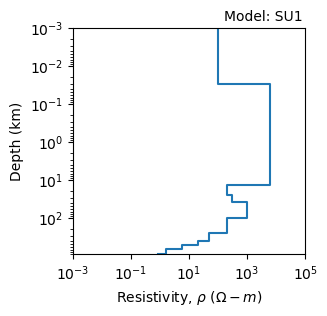

In [3]:
################################################################
# Create SU-1 Earth resistivity model and plot it with depth
################################################################
model_name = "SU1"
site = bezpy.mt.get_1d_site(model_name)
fig = plt.figure(dpi=100, figsize=(3,3))
ax = fig.add_subplot(111)
plot_resistivity(site, ax)

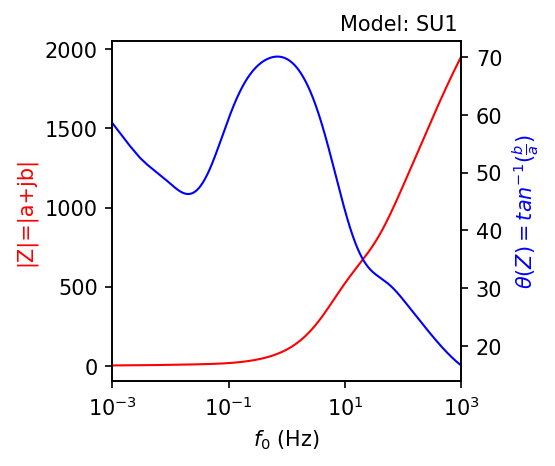

In [4]:
################################################################
# Estimate Earth surface impedance from 1D resistivity model 
# and plot it with frequency
################################################################
flim = 1e-3, 1e3
freqs = np.linspace(flim[0], flim[1], int(flim[1]/flim[0])+1)
Z = site.calcZ(freqs)[1,:]
fig = plt.figure(dpi=150, figsize=(3,3))
ax = fig.add_subplot(111)
plot_impedance_top_layer(site, Z, freqs, ax)

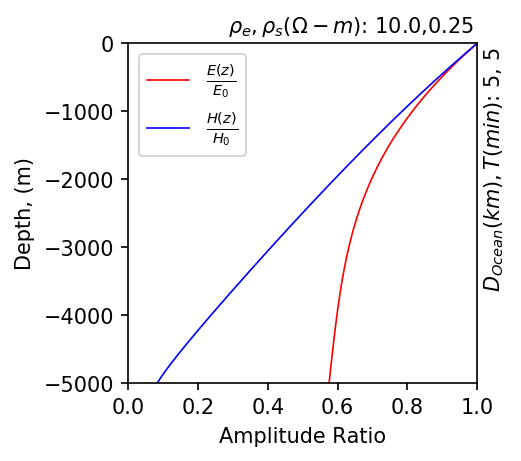

In [5]:
################################################################
# Estimate Hd/Ho and Ed/Eo for a fixed ocean depth, frequency 
# sea and seafloor resistivity
################################################################
H_ratio, E_ratio, z = calculate_E_B_ratios_sea_different_levels()
fig = plt.figure(dpi=150, figsize=(3,3))
ax = fig.add_subplot(111)
plot_E_B_ratios(H_ratio, E_ratio, z, ax)

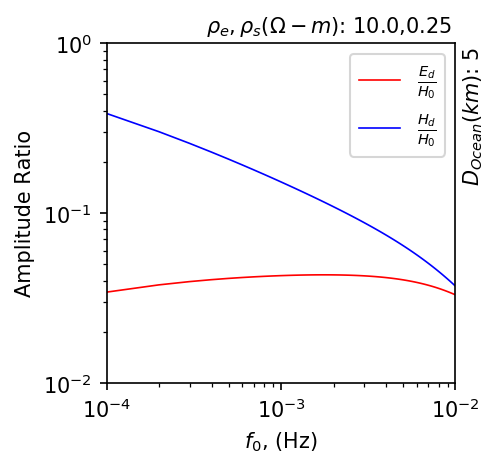

In [6]:
################################################################
# Variations in Hd/Ho and Ed/Ho for a fixed ocean depth, 
# sea and seafloor resistivity with frequency
################################################################
flim = 1e-4, 1e-2
freqs = np.linspace(flim[0], flim[1], int(flim[1]/flim[0])+1)
Ed2H0_ratio, Hd2H0_ratio = calculate_EB_ratio_sea_surface2floor(freqs)
fig = plt.figure(dpi=150, figsize=(3,3))
ax = fig.add_subplot(111)
plot_EB_ratio_sea_surface2floor(freqs, Ed2H0_ratio, Hd2H0_ratio, ax)

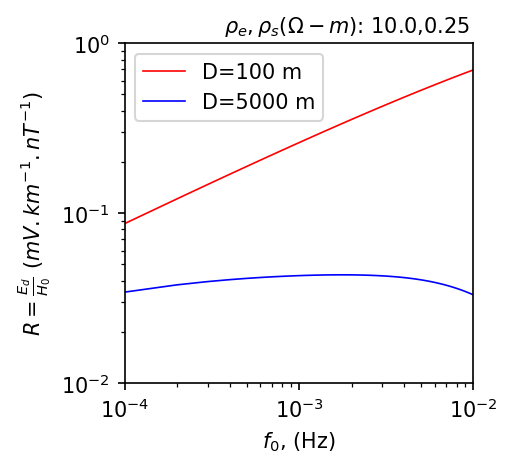

In [7]:
################################################################
# Variations in Ed/Ho for two different ocean depths, 
# and fixed sea and seafloor resistivity, with frequency
################################################################
flim = 1e-4, 1e-2
freqs = np.linspace(flim[0], flim[1], int(flim[1]/flim[0])+1)
Ed2H0_ratio_100m, _ = calculate_EB_ratio_sea_surface2floor(freqs, d=100)
Ed2H0_ratio_5000m, _ = calculate_EB_ratio_sea_surface2floor(freqs)
fig = plt.figure(dpi=150, figsize=(3,3))
ax = fig.add_subplot(111)
plot_ratios_sea_surface2floor(freqs, [Ed2H0_ratio_100m, Ed2H0_ratio_5000m], [100, 5000], ax)

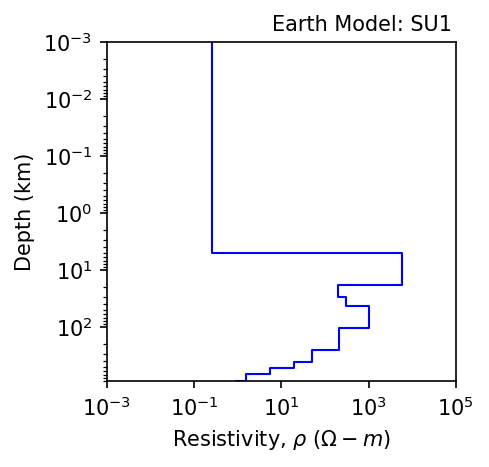

In [8]:
# Import 1D sea-earth model
from models import LayeredOcean
lo = LayeredOcean()
fig = plt.figure(dpi=150, figsize=(3,3))
ax = fig.add_subplot(111)
lo.plot_resistivity(ax)

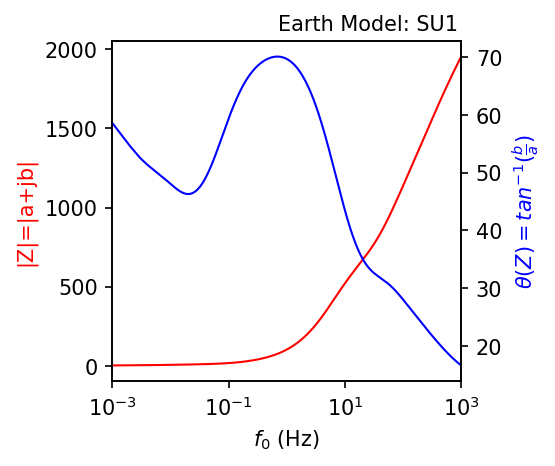

In [9]:
lo.calcZfloor()
fig = plt.figure(dpi=150, figsize=(3,3))
ax = fig.add_subplot(111)
lo.plot_impedance_seafloor(ax)

{'Ed2Ho': array([4.93967557e-005-6.52809117e-006j, 4.76382486e-005-1.27650491e-005j,
        4.48566181e-005-1.84511802e-005j, ...,
        8.37345155e-275+8.38379928e-275j, 8.37345816e-275+8.37853985e-275j,
        8.37346311e-275+8.37328207e-275j]),
 'Hd2Ho': array([1.49293095e-005-3.36535015e-005j, 8.19762424e-006-2.20479300e-005j,
        4.77336994e-006-1.76602681e-005j, ...,
        5.33067884e-278+2.88649856e-278j, 5.32991233e-278+2.88391887e-278j,
        5.32914525e-278+2.88134024e-278j])}

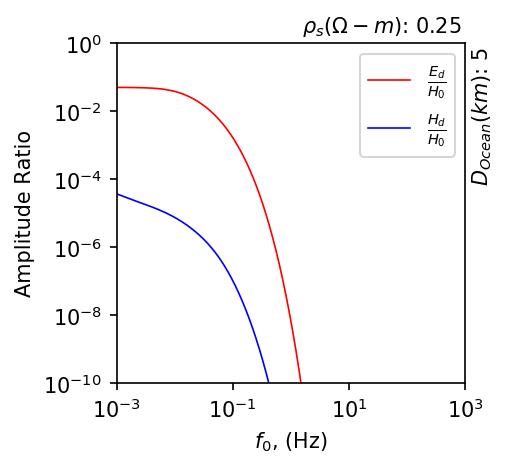

In [10]:
fig = plt.figure(dpi=150, figsize=(3,3))
ax = fig.add_subplot(111)
lo.calcTF(ax=ax)